In [62]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import igraph

In [63]:
# Define your data directory
data_dir = "/Users/pradeepchowdary/Desktop/spatial transcriptomics/data"

# Read Visium-formatted data (Scanpy automatically finds .h5 + spatial/ folder)
adata = sc.read_visium(path=data_dir, load_images=True)

# Show summary
adata

/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

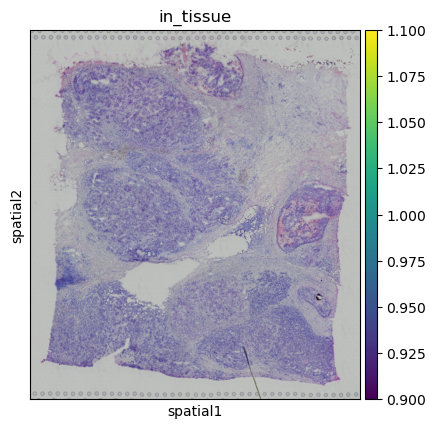

In [64]:
# Plot the tissue section image with Visium spots overlaid.
# Spots are colored based on whether they are in tissue (1) or not (0).
# This helps us visually confirm which capture spots contain real tissue for downstream analysis.
sc.pl.spatial(adata, color="in_tissue", spot_size=1.3)

In [65]:
# Keep only spots that captured actual tissue (in_tissue == 1)
# This filters out background spots that do not contain any meaningful biological data
adata = adata[adata.obs["in_tissue"] == 1].copy()

/opt/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [66]:
# Step 1: Normalize total counts per spot to 10,000
# This ensures all spots (locations on the tissue) have the same total gene expression,
# so that differences in total RNA captured don't affect our analysis.
sc.pp.normalize_total(adata, target_sum=1e4)

# Step 2: Log-transform the data using log(x + 1)
# This reduces the effect of very large gene expression values and spreads out smaller ones,
# making the data more balanced and easier to analyze (e.g., for PCA and clustering).
sc.pp.log1p(adata)

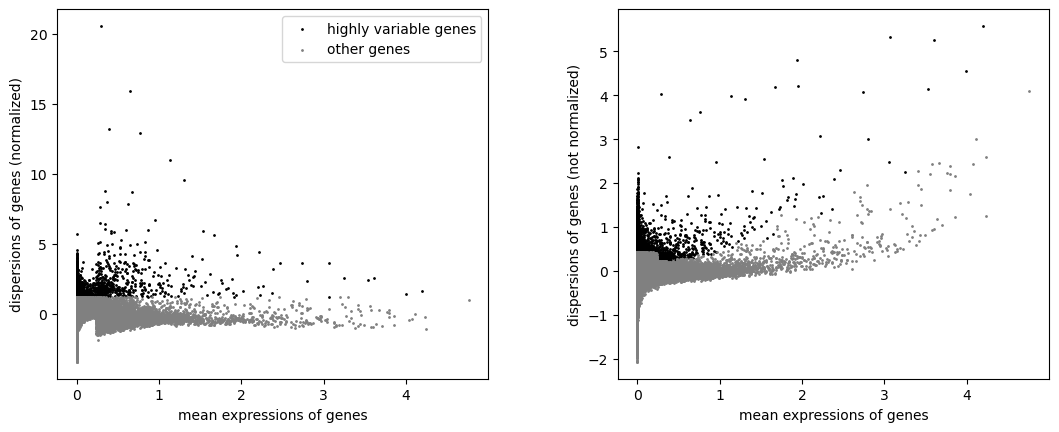

In [67]:
# Select top 2000 highly variable genes to focus on informative genes for downstream analysis
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

# Plot to visualize which genes were selected as highly variable (highlighted in blue)
sc.pl.highly_variable_genes(adata)

In [68]:
# Keep only the highly variable genes for analysis to reduce noise and improve efficiency
adata = adata[:, adata.var.highly_variable]

/opt/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


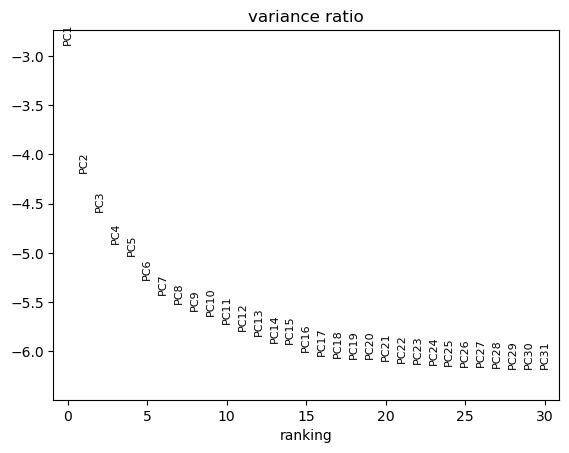

In [69]:
# Normalize gene expression to unit variance (clipping extreme values to 10) to prepare for PCA
sc.pp.scale(adata, max_value=10)

# Perform PCA to reduce dimensionality while preserving variance
sc.tl.pca(adata, svd_solver='arpack')

# Visualize how much variance each principal component explains (log scale)
sc.pl.pca_variance_ratio(adata, log=True)

In [70]:
# Compute a neighborhood graph using the first 30 principal components
# This finds the 10 nearest neighbors of each spot in PCA space, which is used for clustering and visualization
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

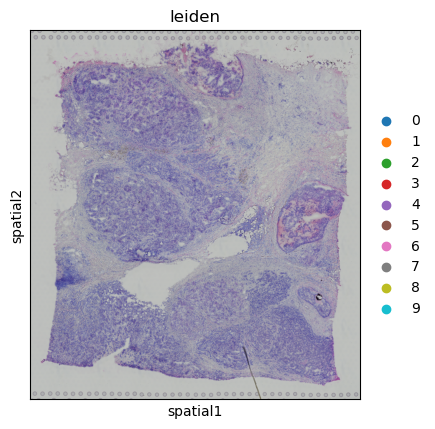

In [71]:
# Perform Leiden clustering to group spots with similar expression profiles
# The `resolution=0.5` controls cluster granularity (higher = more clusters)
sc.tl.leiden(adata, resolution=0.5)

# Visualize the Leiden clusters on the spatial tissue image
# Each color represents a different cluster of biologically similar spots
sc.pl.spatial(adata, color="leiden", spot_size=1.3)

In [72]:
# Identify marker genes for each Leiden cluster using the Wilcoxon rank-sum test
# This finds genes that are significantly more expressed in one cluster compared to others
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_ra

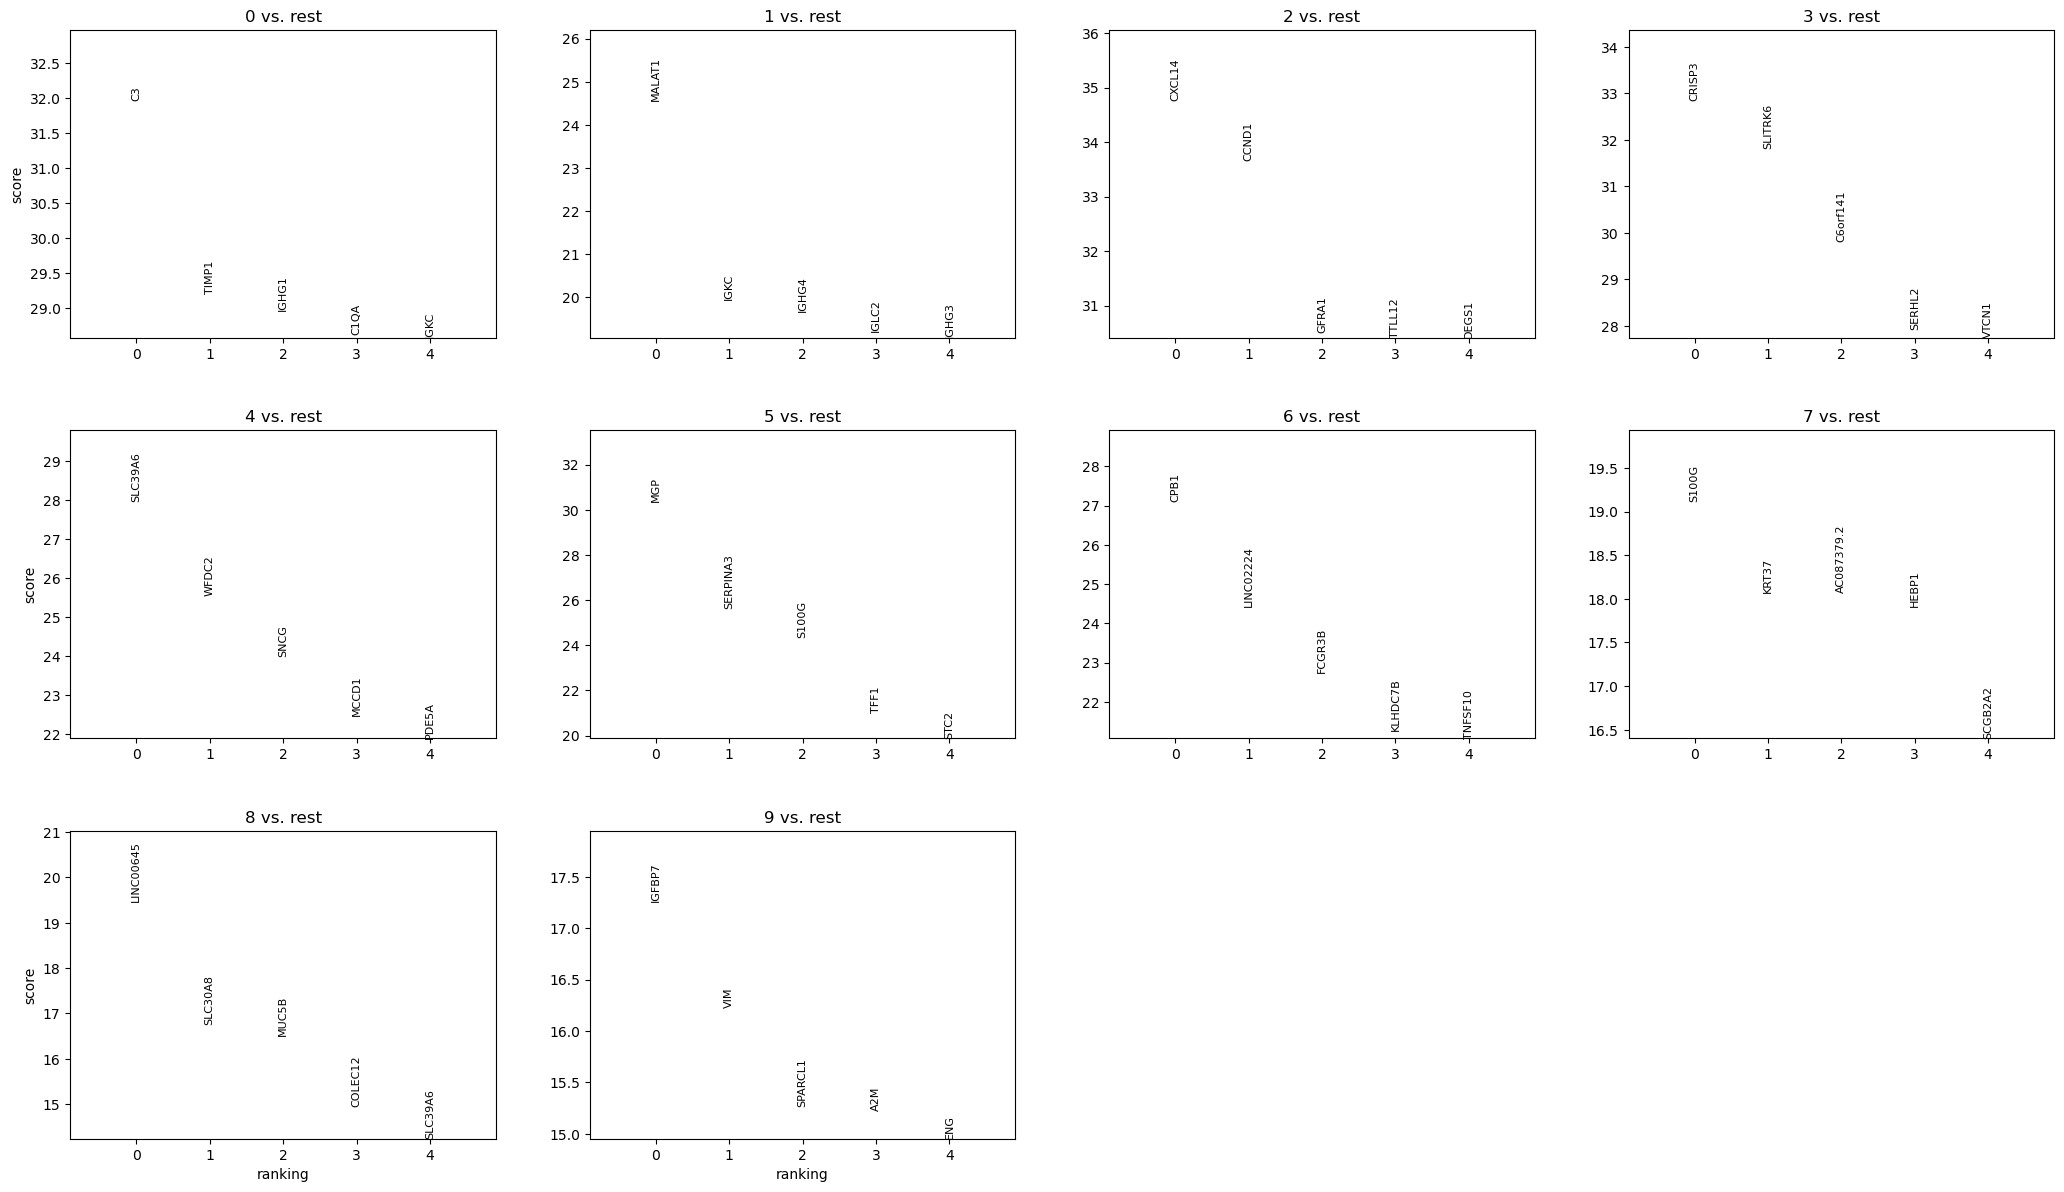

In [73]:
# Visualize the top 5 marker genes for each Leiden cluster
# This helps identify genes that define each cluster, aiding in cell type annotation
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)

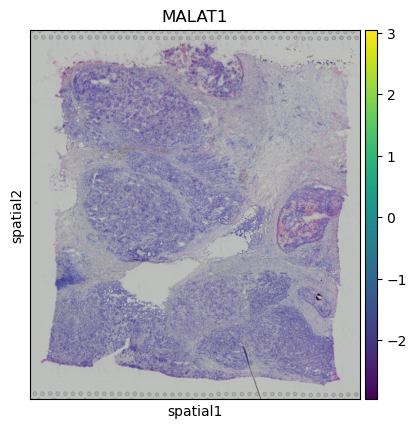

In [74]:
# Plot spatial expression of the gene "MALAT1" on the tissue slide
# Helps visualize where this specific gene is highly expressed across the tissue
sc.pl.spatial(adata, color=["MALAT1"], spot_size=1.3)

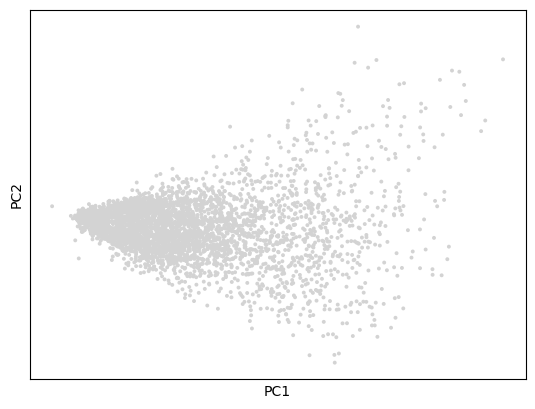

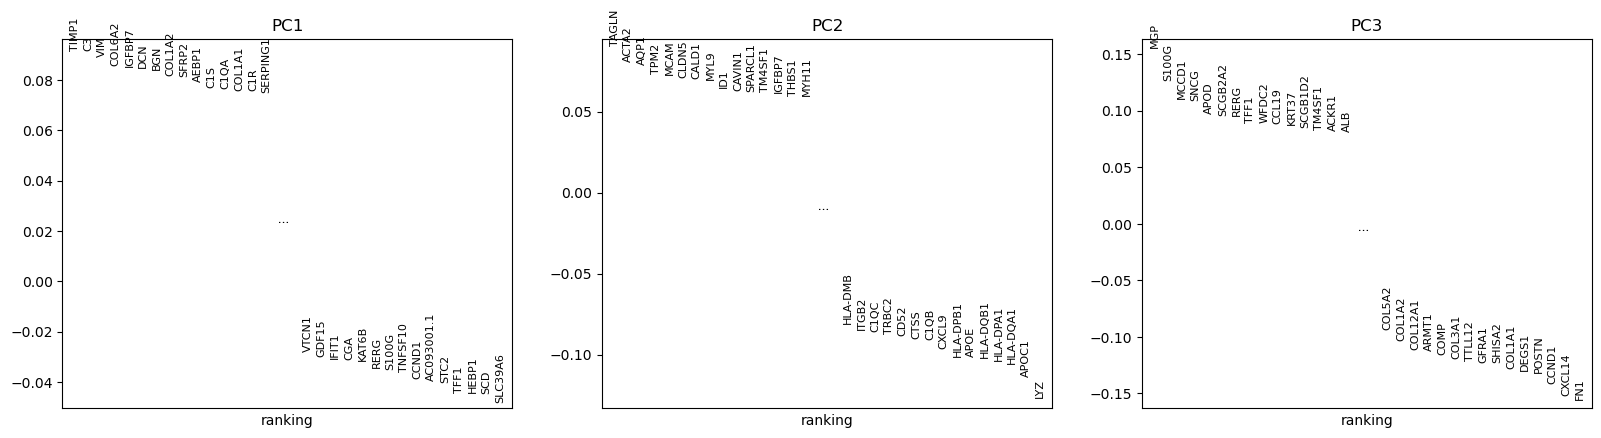

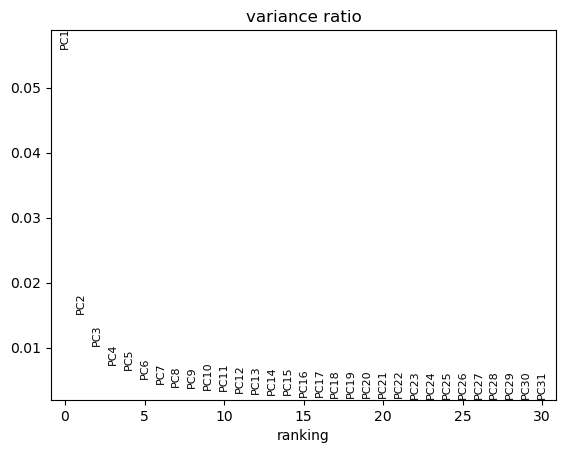

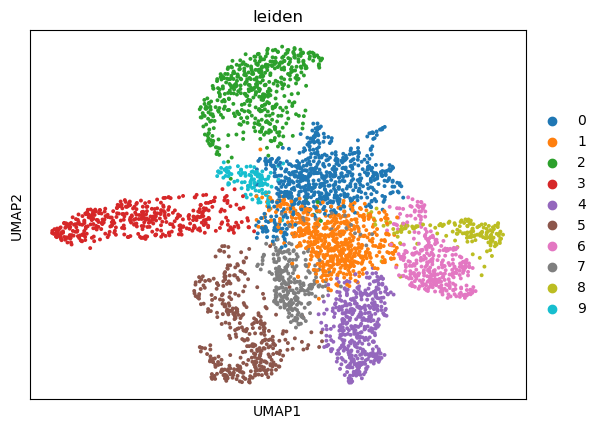

In [75]:
sc.tl.pca(adata)  
# Step 1: Perform Principal Component Analysis (PCA) to reduce dimensionality of the gene expression data
# This helps in simplifying the data while retaining most of its variation

sc.pl.pca_overview(adata)  
# Step 2 (optional): Visualize variance explained by each principal component
# Useful for understanding how much information is preserved in the first few components

sc.tl.umap(adata)  
# Step 3: Compute UMAP (Uniform Manifold Approximation and Projection) for 2D visualization
# UMAP reveals structure in the data like clustering patterns in lower dimensions

sc.pl.umap(adata, color=["leiden"])  
# Step 4: Plot UMAP with Leiden cluster colors
# Helps visualize how spatial clusters group together in the reduced UMAP space

In [76]:
cluster_map = {
    "0": "Immune cells (APCs)",
    "1": "Tumor (General)",
    "2": "Proliferative Tumor",
    "3": "Endothelial / Stromal",
    "4": "Hypoxic Tumor Core",
    "5": "Stressed Tumor / Fibroblast",
    "6": "Macrophages",
    "7": "Fibroblasts / ECM",
    "8": "Epithelial Cells",
    "9": "Stromal / Mesenchymal"
}

# Assign descriptive cell type names to each Leiden cluster using the mapping
# This helps give biological meaning to the clusters based on known marker genes
adata.obs["cell_type"] = adata.obs["leiden"].map(cluster_map)

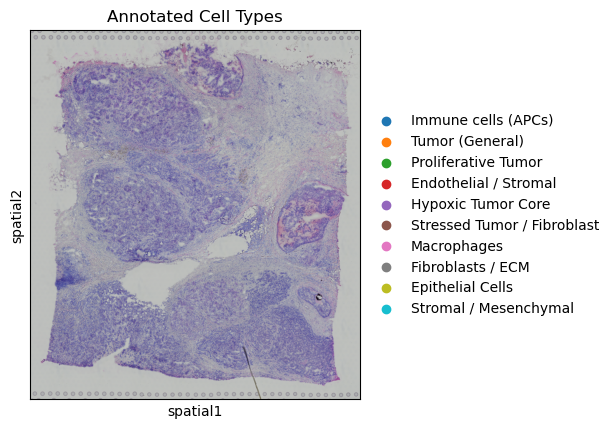

In [77]:
# Visualize the spatial distribution of annotated cell types on the tissue image
# Each spot is colored by its assigned cell type, giving biological context to spatial locations
sc.pl.spatial(adata, color="cell_type", spot_size=1.3, title="Annotated Cell Types")

/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/anaconda3/lib/python3.11/site-packages/scanpy/tools/_ra

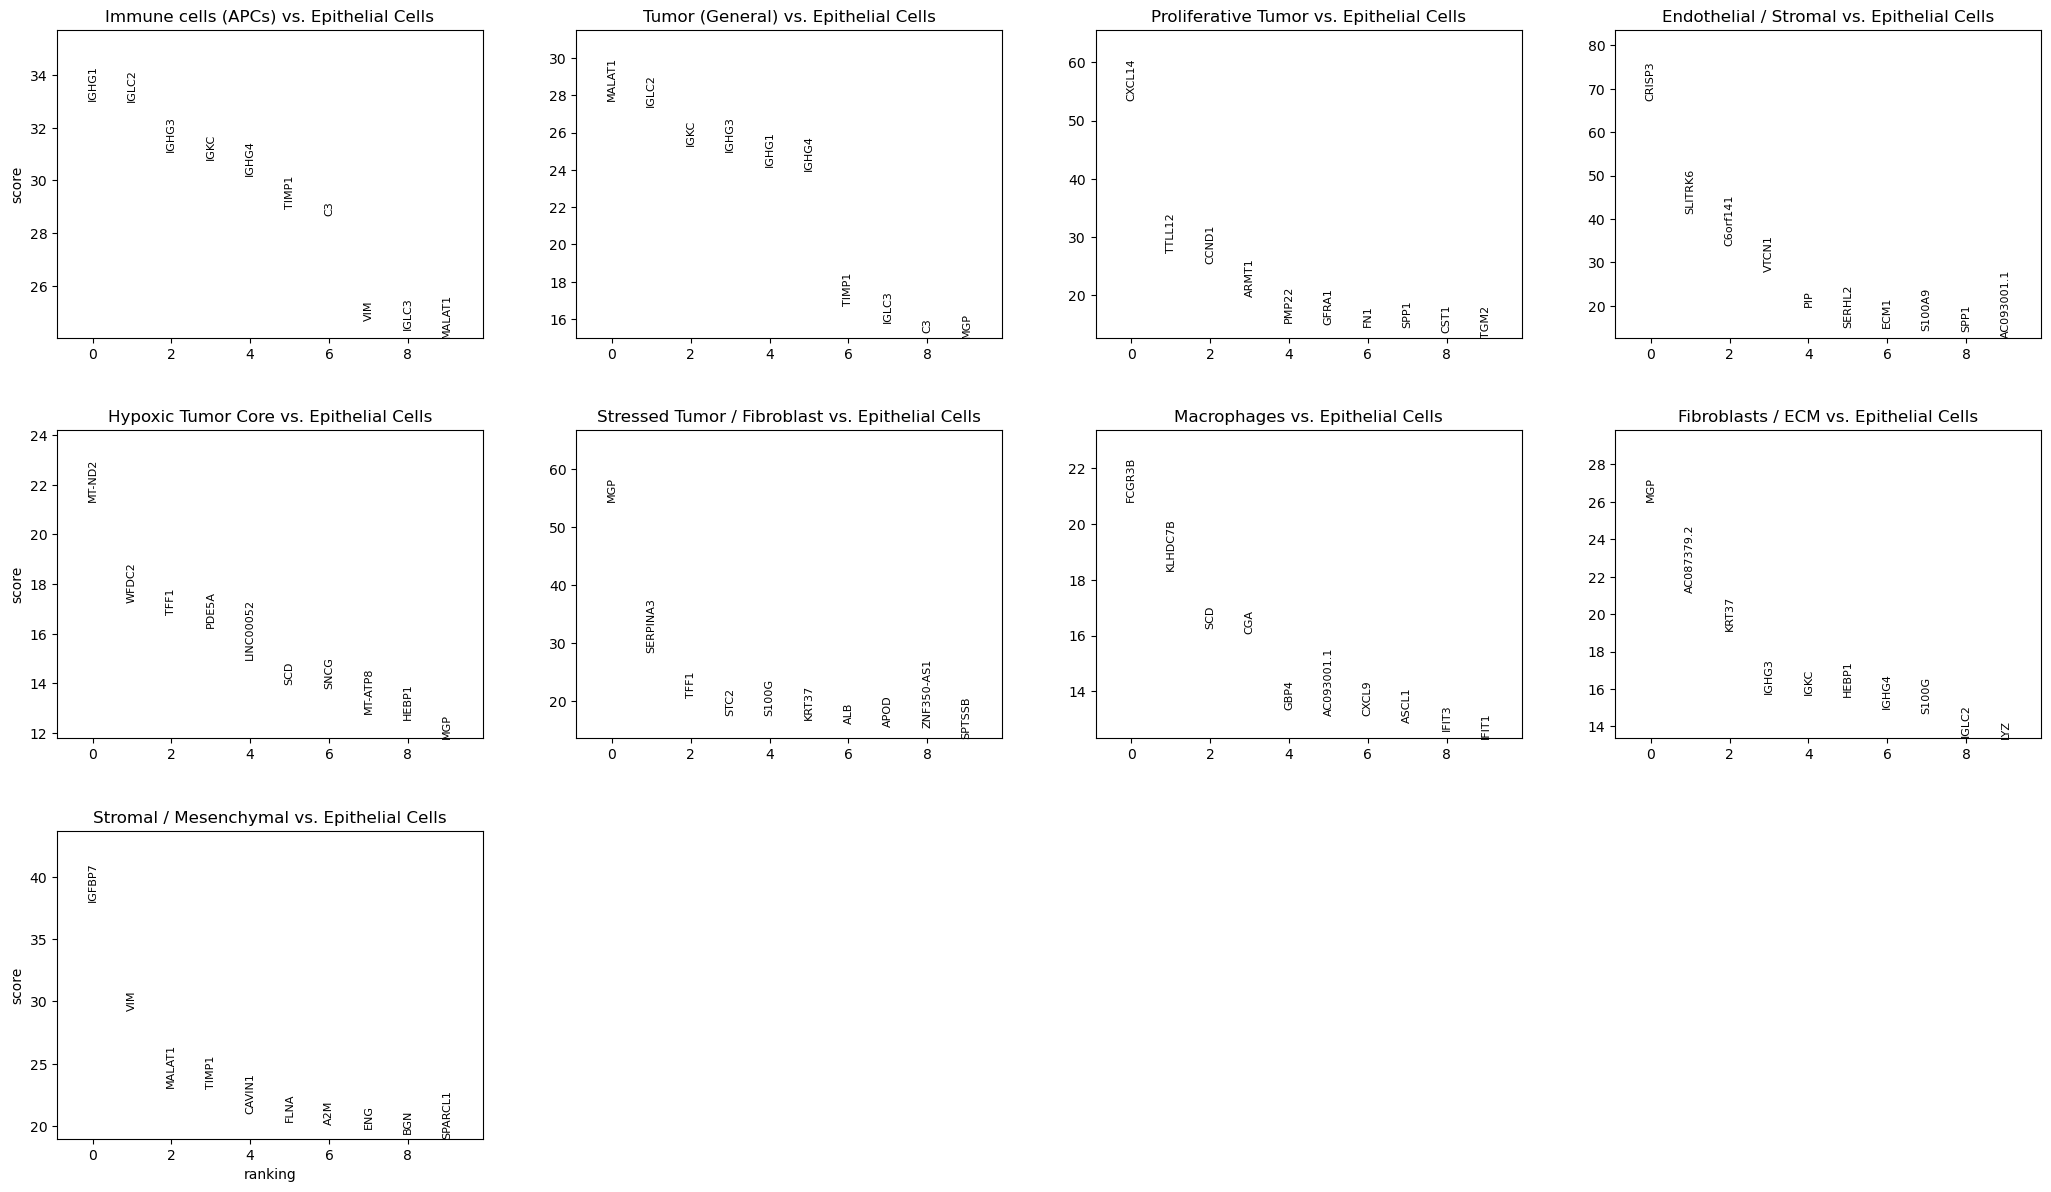

In [78]:
# Identify marker genes for each cell type by comparing to "Epithelial Cells" as a reference
# Uses the Wilcoxon rank-sum test to find genes significantly upregulated in other cell types
sc.tl.rank_genes_groups(adata, groupby="cell_type", reference="Epithelial Cells")

# Plot top 10 marker genes per cell type compared to epithelial cells
# Helps visualize which genes define each cell type
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)